In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
#mpl.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import os
import datetime
#import seaborn as sns
import timeit
import random
from dask.diagnostics import ProgressBar
from functools import partial
import dask


#fft packages
from scipy import fftpack
import math
from scipy import fft
from scipy import ndimage
from scipy import signal

In [2]:
#%% plot parameters
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally
plt.rc('font', family='serif',size = 22)  # controls default text layout
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

#sns.set()
#plt.minorticks_on()

plt.rc('text', usetex=False)


In [3]:
#setting progress bar visible
ProgressBar().register()
#making sure that xarray/dask splits large chunks while reading in data
dask.config.set({"array.slicing.split_large_chunks": True})

In [4]:
def _subset_process_time(ds,var,iop):
    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02':ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03':ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)

#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num)
            #IOP03
            if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num)         
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','u','v']
            partial_func = partial(_subset_process_time, var=var,iop=iop)
            ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
            ds.close()
            #check if the time index has only unique values 
            u, c = np.unique(ds.time.values, return_counts=True)
            #if not, keep the second, latest value for the ds
            if np.sum(c > 1) > 0 : ds = ds.drop_duplicates(dim='time', keep='last')            
            print('Member',str(member_num),'finished collecting data')    
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close()
        #check if the time index has only unique values 
        u, c = np.unique(ds.time.values, return_counts=True)
        #if not, keep the second, latest value for the ds
        if np.sum(c > 1) > 0 : ds = ds.drop_duplicates(dim='time', keep='last')        
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)




In [5]:
def calc_u_star(ds,w_level):
    #above canopy momentum fluxes
    w_av = ds.w.sel(zw_3d=w_level)#[1:]

    uw_av = ds.uw.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'xu': 'x'}).interp_like(ds.v)
    u_av = ds.u.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'xu': 'x'}).interp_like(ds.v)#[1:]
    uprime_wprime = (uw_av - u_av*w_av)

    vw_av = ds.vw.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'yv': 'y'}).interp_like(ds.u)#[1:]#[1:]
    v_av = ds.v.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'yv': 'y'}).interp_like(ds.u)#[1:]
    vprime_wprime = (vw_av - v_av*w_av)

    time_stamp =  (uw_av['time'].dt.strftime('%H:%M'))

    #above canopy u*
    u_star = (uprime_wprime**2 + vprime_wprime**2)**(0.25)
    
    return u_star

def u_star_list(ds,time_array):
    
    u_star_list = []
    
    for time_step in time_array:
        u_star_val = calc_u_star(ds.sel(zw_3d = slice (0,60),zu_3d = slice (0,60),time=time_step),36).mean().compute().values
        u_star_list.append(u_star_val)
    return u_star_list

In [6]:
def belltaper(var, n): #-- following Stull 1999
    W = [] # weight function 
    for i in np.arange(n):
        if (i/n > 0.1) & (i/n < 0.9):
            W.append(1)
        else:
            W.append(math.sin(np.pi*i/n)**2)
    out = var * W
    return(out)

def rotate_var (var,factor,wind_angle):
    data_array = var.values

    #scipy ndimage needs integer valued arrays for rotation
    #so multiplying and dividing by 1000 to convert to and back from 3 degree precision integers
    rotated_data = ((ndimage.rotate(np.nan_to_num((data_array*factor)).astype(int), angle=wind_angle,reshape=False))/factor)
    # plt.imshow(data_array,origin = 'lower', cmap = 'RdBu_r')
    # plt.colorbar()
    return rotated_data


In [11]:
#select w data for 23 Aug 1100, at 0.5 zi
IOP02_time_array = ['2019-08-23T09:00:00.000000000', '2019-08-23T09:30:00.000000000',
       '2019-08-23T10:00:00.000000000', '2019-08-23T10:30:00.000000000',
       '2019-08-23T11:00:00.000000000', '2019-08-23T11:30:00.000000000',
       '2019-08-23T12:00:00.000000000', '2019-08-23T12:30:00.000000000',
       '2019-08-23T13:00:00.000000000', '2019-08-23T13:30:00.000000000',
       '2019-08-23T14:00:00.000000000', '2019-08-23T14:30:00.000000000',
       '2019-08-23T15:00:00.000000000', '2019-08-23T15:30:00.000000000',
       '2019-08-23T16:00:00.000000000']

zi_iop02  =  [ 127.26811317,  186.28140789,  395.95448875,  490.1812074 ,
        767.58835375, 1194.99948318, 1242.73773669, 1400.52554689,
       1532.84613054, 1549.20057474, 1585.96478949, 1593.99945645,
       1598.73579416, 1618.02875473, 1621.44236578] 

w_star_iop02 = [0.65544301, 0.8218802 , 1.15222044, 1.33399153, 1.55739   ,
       1.80245719, 1.79051632, 1.88647701, 2.07238861, 2.06652333,
       2.0011327 , 1.89977991, 1.93889857, 1.9215422 , 1.82642433]


mean_wind_dir_degrees_list = [ 25.1624835 ,  18.75041802,   8.102142  ,   8.89602428,
        14.24730503,  16.02565065,  13.37958926,   6.69618812,
         2.57431922,   6.51778016,  -1.47654069, -20.7259512 ,
       -27.05573339, -26.00877809, -33.35672462]

wind_angle = 180+np.asarray(mean_wind_dir_degrees_list) #at 11 for iop02, u and v are negative, so wind angle = 180+cartesian angle

#subset for the 10x10 smaller domain 
x_min = 449-167
x_max = 449+168

y_min = 503-167
y_max = 503+168


Spectra for the instantaneous and 30-minute mean data for 1100, 23 August

In [10]:
member_list = np.arange(1,9)

fname = 'DATA_3D_NETCDF_N02slice'
ensemble_ds_iop02_N02_list = open_concat_member_files(member_list,fname,'iop02')
ensemble_ds_iop02_N02 = xr.concat(ensemble_ds_iop02_N02_list,dim='ensemble')


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.26684695109725 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.22520800679922104 seconds
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.22886007279157639 seconds
['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with member 4  Time elapsed  0.3458

In [12]:
ensemble_member_ds_2_N02_iop02 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop02')
ds_2_het_iop02 = ensemble_member_ds_2_N02_iop02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

def adjust_axis(ds):    
    ds['x'] = ds.x - ds.x[0]
    ds['y'] = ds.y - ds.y[0]
    ds['xu'] = ds.xu - ds.xu[0]
    ds['yv'] = ds.yv - ds.yv[0]    
    return (ds)

ds_2_het_iop02 = adjust_axis(ds_2_het_iop02)


['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.4221591278910637 seconds


In [16]:
member_list = np.arange(1,9)
fname = 'DATA_3D_AV_NETCDF_N02slice'

PS_array_x = []
PS_array_y = []
time_index = 4
print(IOP02_time_array[time_index])
for i, member_num in enumerate(member_list):

    rotating_factor = 1000000
    var_cross_section = open_concat_member_files(member_num,fname,'iop02').w.sel(time=IOP02_time_array[time_index],zw_3d=zi_iop02[time_index]/2,method='nearest').squeeze()

    #rotate to the mean wind and subset to the smaller domain
    var_data = rotate_var(var_cross_section,rotating_factor,wind_angle[time_index])[x_min:x_max,y_min:y_max]

    x = ds_2_het_iop02.x.values
    y = ds_2_het_iop02.y.values

    # number of obsevations in x- and y-direction
    Nx = x.size
    Ny = y.size

    # # find center of area
    xlocs = np.round(np.arange(0,Nx),0).astype(int)
    ylocs = np.round(np.arange(0,Ny),0).astype(int)

    lx = []
    ly = []
    Sx_list = []
    Sy_list = []
    # loop trhough all transects to determine Lh, then average over Lh
    for i in np.arange(len(xlocs)):
        yloc=ylocs[i]
        xloc=xlocs[i]
        # extract x- and y-transects of surface temperature --> fluctuation around mean only!
        #sp switching the order here

        data_y = var_data[:,xloc]-var_data[:,xloc].mean()
        data_x = var_data[yloc,:]-var_data[yloc,:].mean()

        # #-- apply bell taper to space series
        # Tx_bt = belltaper(Tx,Nx)     
        # Ty_bt = belltaper(Ty,Ny)

        # #-- apply bell taper to space series
        data_x_bt = belltaper(data_x,Nx)     
        data_y_bt = belltaper(data_y,Ny)


        #-- calculate wave vectors
        # grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        # dimensions of whole domain
        Lx = dx*Nx
        Ly = dy*Ny
        # nyquist aliasing frequency
        nyquist_x = np.power(dx,-1)/2
        nyquist_y = np.power(dy,-1)/2
        # wave vector increments
        delta_kx = np.power(Lx,-1)
        delta_ky = np.power(Ly,-1)
        # frequencies according to Frederik's python scripts
        k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
        k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
        # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
        # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
        # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
        # calculate spectral contributions
        Sx = (np.abs(fftpack.fft(data_x_bt)**2)[:int(Nx/2)])
        Sx_list.append(Sx)
        Sy = (np.abs(fftpack.fft(data_y_bt)**2)[:int(Ny/2)])           
        Sy_list.append(Sy)
    #mean spectral power in x and y directions
    S_x = np.mean(Sx_list,0)
    S_y = np.mean(Sy_list,0)
    PS_array_x.append(S_x/np.sum(S_x))
    PS_array_y.append(S_y/np.sum(S_y))
    # PS_array_x.append(S_x/w_star_iop02[time_index]**2)
    # PS_array_y.append(S_y/w_star_iop02[time_index]**2)
    # PS_array_x.append(S_x/theta_star_iop02[time_index]**2)
    # PS_array_y.append(S_y/theta_star_iop02[time_index]**2)
    # PS_array_x.append(S_x/q_star_iop02[time_index]**2)
    # PS_array_y.append(S_y/q_star_iop02[time_index]**2)


#spatial_freq = (fft.rfftfreq(var_windowed_data.shape[0],30))[1:]
#spatial_freq = spatial_freq[3:]
spatial_freq_x = k_x
spatial_freq_y = k_y
PS_array_x = np.asarray(PS_array_x)
PS_array_y = np.asarray(PS_array_y)



2019-08-23T11:00:00.000000000
['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.4018707722425461 seconds
[########################################] | 100% Completed | 102.56 ms
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.7722920589148998 seconds
[########################################] | 100% Completed | 101.72 ms
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.3325936459004879 seconds
[########################################] | 100% Comple

In [17]:
mean_PS_array_y = np.mean(PS_array_y,0)

#turbulent_spectra_11 = mean_PS_array_y
thirty_min_spectra_11 = mean_PS_array_y


calculate the heterogeneity induced fields

In [18]:
iop = 'iop02'
fname = 'DATA_3D_AV_NETCDF_N02slice'

time_index = 4

time_step = IOP02_time_array[time_index]
print(time_step)

zi = zi_iop02[time_index] #1100, iop02

data_list = []
#loop through the member list to select the 3D var value at the time step from each member
for member in member_list:
    #following line of code will concatenate all the data files of input_fname from member_num
    #and select the var at time sim_time
    ds = open_concat_member_files(member,fname,iop).sel(time=time_step)[['w']]
    # #subset for the smaller domain
    # ds = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02[time_index]+200),zw_3d=slice(None,zi_iop02[time_index]+200))
    #subset for the abl height
    ds = ds.sel(zw_3d=zi_iop02[time_index]/2,method='nearest')
    
    #append the data to the list
    data_list.append(ds)


ensemble_ds = xr.concat(data_list,'ensemble')    
print('Calculating hi datasets..')
print('w_hi..')
#hi datasets

w_ensemble_time_mean = ensemble_ds.w.mean('ensemble')
w_space_time_mean = ensemble_ds.w.mean('ensemble').isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).mean('x').mean('y')
w_hi = (w_ensemble_time_mean - w_space_time_mean).compute()


2019-08-23T11:00:00.000000000
['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.3703809268772602 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3150906264781952 seconds
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.32109327986836433 seconds
['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with

In [19]:
PS_array_x = []
PS_array_y = []


rotating_factor = 1000000
var_cross_section = w_hi

#rotate to the mean wind and subset to the smaller domain
var_data = rotate_var(var_cross_section,rotating_factor,wind_angle[4])[x_min:x_max,y_min:y_max]

x = ds_2_het_iop02.x.values
y = ds_2_het_iop02.y.values

# number of obsevations in x- and y-direction
Nx = x.size
Ny = y.size

# # find center of area
xlocs = np.round(np.arange(0,Nx),0).astype(int)
ylocs = np.round(np.arange(0,Ny),0).astype(int)

lx = []
ly = []
Sx_list = []
Sy_list = []
# loop trhough all transects to determine Lh, then average over Lh
for i in np.arange(len(xlocs)):
    yloc=ylocs[i]
    xloc=xlocs[i]
    # extract x- and y-transects of surface temperature --> fluctuation around mean only!
    #sp switching the order here

    data_y = var_data[:,xloc]-var_data[:,xloc].mean()
    data_x = var_data[yloc,:]-var_data[yloc,:].mean()

    # #-- apply bell taper to space series
    # Tx_bt = belltaper(Tx,Nx)     
    # Ty_bt = belltaper(Ty,Ny)

    # #-- apply bell taper to space series
    data_x_bt = belltaper(data_x,Nx)     
    data_y_bt = belltaper(data_y,Ny)


    #-- calculate wave vectors
    # grid spacing
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    # dimensions of whole domain
    Lx = dx*Nx
    Ly = dy*Ny
    # nyquist aliasing frequency
    nyquist_x = np.power(dx,-1)/2
    nyquist_y = np.power(dy,-1)/2
    # wave vector increments
    delta_kx = np.power(Lx,-1)
    delta_ky = np.power(Ly,-1)
    # frequencies according to Frederik's python scripts
    k_x = np.linspace(delta_kx,nyquist_x,int(Nx/2)) # !!! might be an issue when nx is uneven
    k_y = np.linspace(delta_ky,nyquist_y,int(Ny/2)) # !!! might be an issue when nx is uneven
    # calculate frequencies of (Fourier transform) # !!! basically the same as k_y and k_x but starts at zero!
    # k_x = fftpack.fftshift(fftpack.fftfreq(Nx,d=dx))[int(len(x)/2):] # only positive half of spectrum
    # k_y = fftpack.fftshift(fftpack.fftfreq(Ny,d=dy))[int(len(y)/2):]
    # calculate spectral contributions
    Sx = (np.abs(fftpack.fft(data_x_bt)**2)[:int(Nx/2)])
    Sx_list.append(Sx)
    Sy = (np.abs(fftpack.fft(data_y_bt)**2)[:int(Ny/2)])           
    Sy_list.append(Sy)
#mean spectral power in x and y directions
S_x = np.mean(Sx_list,0)
S_y = np.mean(Sy_list,0)
PS_array_x.append(S_x/np.sum(S_x))
PS_array_y.append(S_y/np.sum(S_y))
# PS_array_x.append(S_x/w_star_iop02[time_index]**2)
# PS_array_y.append(S_y/w_star_iop02[time_index]**2)
# PS_array_x.append(S_x/theta_star_iop02[time_index]**2)
# PS_array_y.append(S_y/theta_star_iop02[time_index]**2)
# PS_array_x.append(S_x/q_star_iop02[time_index]**2)
# PS_array_y.append(S_y/q_star_iop02[time_index]**2)


#spatial_freq = (fft.rfftfreq(var_windowed_data.shape[0],30))[1:]
#spatial_freq = spatial_freq[3:]
spatial_freq_x = k_x
spatial_freq_y = k_y
PS_array_x = np.asarray(PS_array_x)
PS_array_y = np.asarray(PS_array_y)



In [20]:
mean_PS_array_y = np.mean(PS_array_y,0)

hi_spectra = mean_PS_array_y

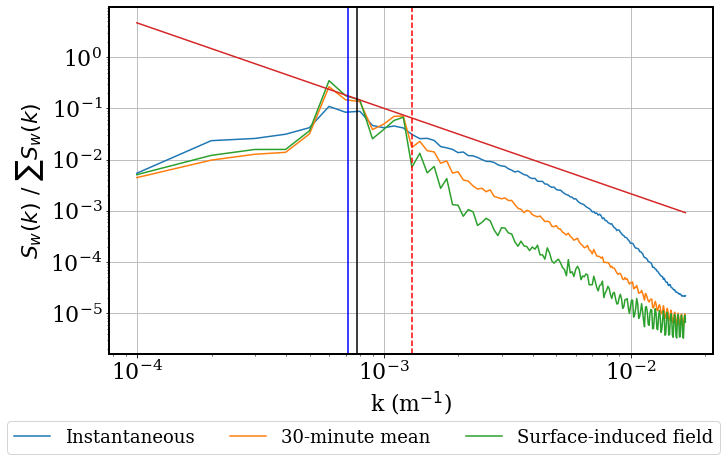

In [24]:
fig = plt.figure(figsize=(10,6))
plt.loglog(spatial_freq_y, (turbulent_spectra_11), label = 'Instantaneous')
plt.loglog(spatial_freq_y, (thirty_min_spectra_11), label = '30-minute mean')
plt.loglog(spatial_freq_y, (hi_spectra), label = 'Surface-induced field')
#plt.loglog(spatial_freq_y, spatial_freq_y**(-5/3))
k53 = 0.000001*spatial_freq_y**(-5/3)
plt.loglog(spatial_freq_y, k53)
plt.axvline(x=1/zi_iop02[4],color='red',linestyle='--')
# plt.axvline(x=1/180,color='blue')
plt.axvline(x=1/1291,color='black')
plt.axvline(x=1/1401,color='blue')
fig.legend(ncol=3,loc="lower center",bbox_to_anchor=(.5, -.08), fontsize=18)

plt.xlabel("k (m$^{-1}$)")
plt.ylabel("$S_w(k)$ / $\sum{S_w(k)}$")
plt.grid()
plt.tight_layout()
output_fname = 'spectra_iop02_1100_w.png'
plt.savefig(output_fname,dpi=300, bbox_inches="tight")

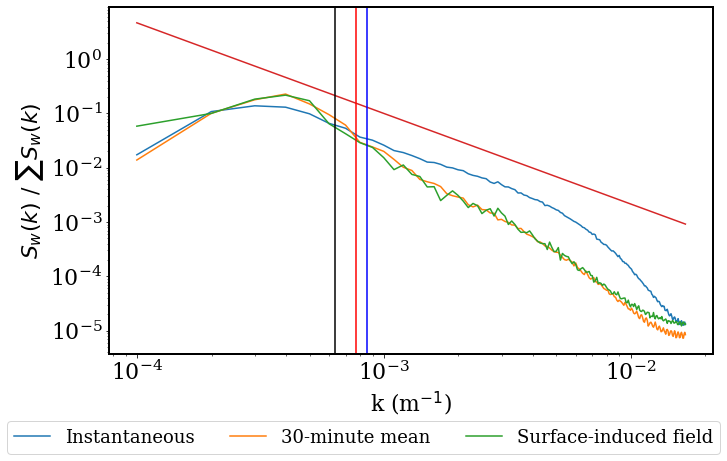

In [147]:
fig = plt.figure(figsize=(10,6))
plt.loglog(spatial_freq_y, (turbulent_spectra_14), label = 'Instantaneous')
plt.loglog(spatial_freq_y, (thirty_min_spectra_14), label = '30-minute mean')
plt.loglog(spatial_freq_y, (hi_spectra_14), label = 'Surface-induced field')
#plt.loglog(spatial_freq_y, spatial_freq_y**(-5/3))
k53 = 0.000001*spatial_freq_y**(-5/3)
plt.loglog(spatial_freq_y, k53)
plt.axvline(x=1/zi_iop02[10],color='black')
# plt.axvline(x=1/180,color='blue')
plt.axvline(x=1/1304,color='red')
plt.axvline(x=1/1170,color='blue')
fig.legend(ncol=3,loc="lower center",bbox_to_anchor=(.5, -.08), fontsize=18)

plt.xlabel("k (m$^{-1}$)")
plt.ylabel("$S_w(k)$ / $\sum{S_w(k)}$")
plt.tight_layout()
# output_fname = 'spectra_iop02_1400_w.png'
# plt.savefig(output_fname,dpi=300, bbox_inches="tight")